In [10]:
# Cell 1: Import Libraries and Define Functions
from segmentation_models_pytorch import utils as smp_utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import segmentation_models_pytorch as smp
import torch
from PIL import Image
from torch.utils.data import DataLoader
import tifffile


In [11]:

# Function to load and process spectral images
def load_spectral_images(x_dir):
    for filename in sorted(os.listdir(x_dir)):
        x_path = os.path.join(x_dir, filename)
        x_image = tifffile.imread(x_path)
        # Assuming the spectral images have multiple bands, select the first 3 bands
        x_image_first_3_bands = x_image[:, :, :3]
        # Save the three-band image back to the same directory with the same filename
        tifffile.imwrite(x_path, x_image_first_3_bands)

# New function to process and predict on a spectral image
def predict_spectral_image(image_path, model, preprocessing_fn, device):
    image = tifffile.imread(image_path)
    image = image[:, :, :3]  # Select first 3 bands
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Preprocess the image
    preprocessing = get_preprocessing(preprocessing_fn)
    sample = preprocessing(image=image)
    image_tensor = torch.from_numpy(sample['image']).unsqueeze(0).to(device)
    
    # Predict the mask
    with torch.no_grad():
        pr_mask = model.predict(image_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy()
    
    return image, pr_mask

# Visualization function
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if len(image.shape) == 3 and image.shape[2] == 3:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='gray')
    plt.show()



In [12]:
# Dataset class definition
class Dataset(BaseDataset):
    CLASSES = ['amphibole', 'k_feldspar2', 'k_feldspar', 'quartz_afg', 'zircon']
    
    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
    
    def __len__(self):
        return len(self.ids)


In [13]:
# Cell 3: Define Augmentation and Preprocessing Functions
# Augmentation and preprocessing functions
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        albu.Perspective(scale=(0.05, 0.1), p=0.5),
        albu.OneOf([
            albu.CLAHE(p=1),
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            albu.RandomGamma(p=1),
        ], p=0.9),
        albu.OneOf([
            albu.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ], p=0.9),
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            albu.HueSaturationValue(p=1),
        ], p=0.9),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [14]:
# Cell 4: Load and Process Spectral Images
# Paths to directories
DATA_DIR = "D:/NARSS/segmentation_models.pytorch/examples/preprocessed_spec_data"
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Load and process spectral images
load_spectral_images(x_train_dir)
load_spectral_images(x_valid_dir)
load_spectral_images(x_test_dir)


In [15]:
# Cell 5: Initialize Model and Create Datasets
# Load the model
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['amphibole', 'quartz_afg', 'zircon', 'k_feldspar2', 'k_feldspar']
ACTIVATION = 'sigmoid'
DEVICE = 'cpu'

model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Create datasets
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)


In [16]:
# Cell 6: Training Setup
# Training setup
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


In [17]:
# Cell 7: Training Loop
# Training loop
max_score = 0

for i in range(0, 1):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
valid: 100%|██████████| 336/336 [05:22<00:00,  1.04it/s, dice_loss - 0.04633, iou_score - 0.9258]
Model saved!


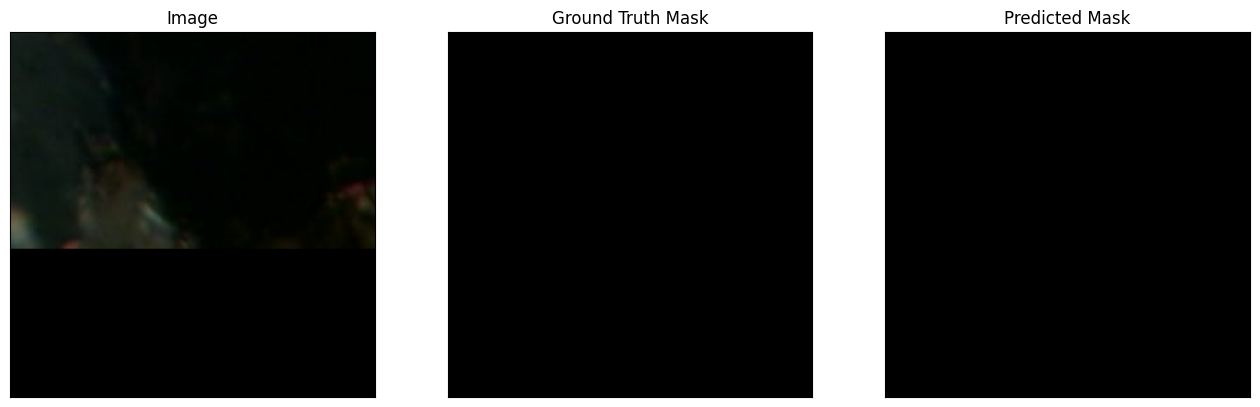

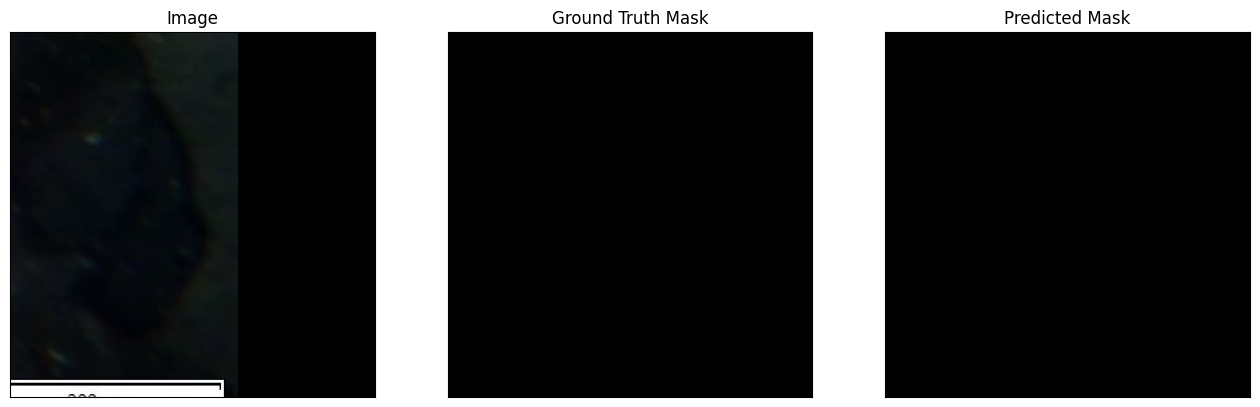

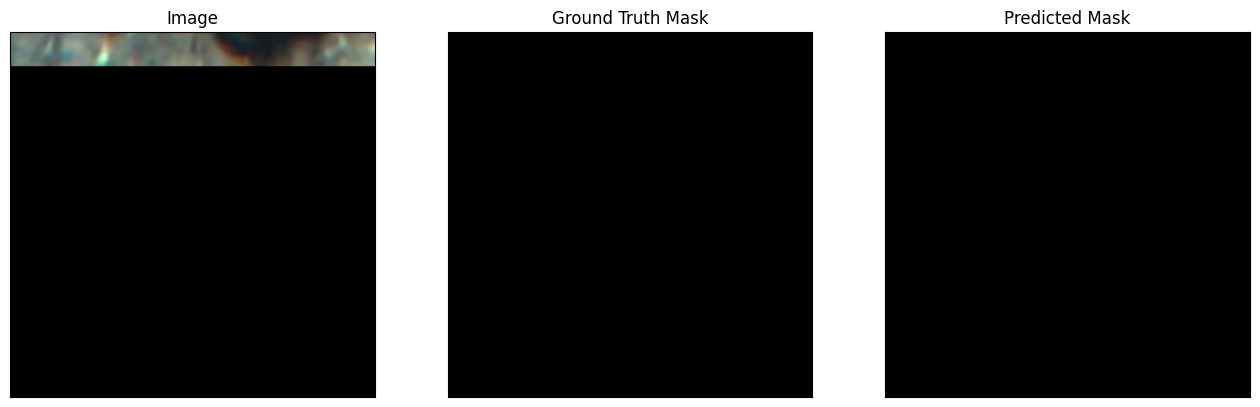

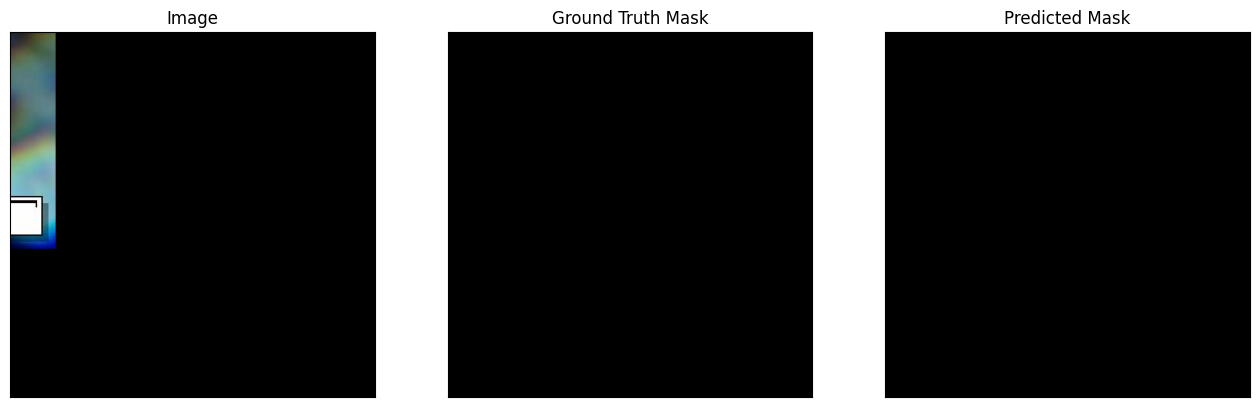

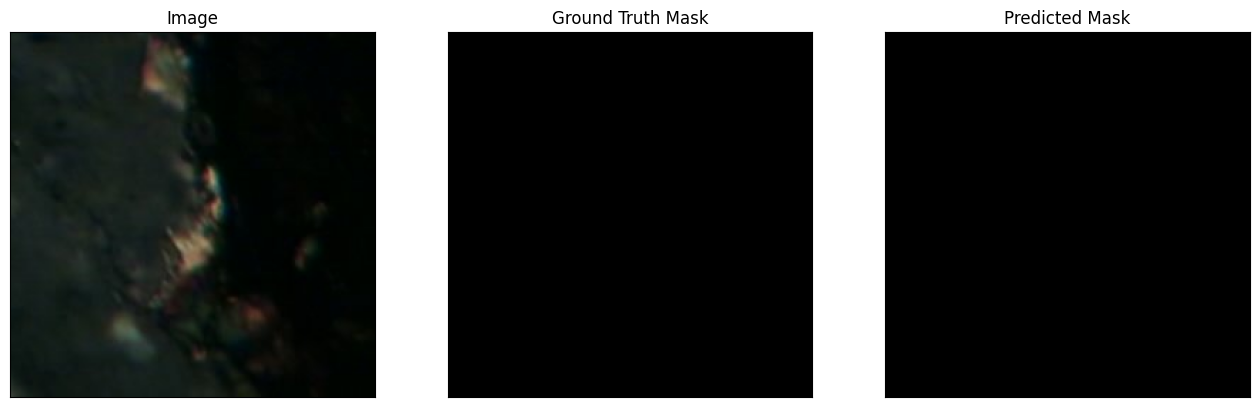

In [18]:
# Load Best Model and Visualize Predictions
# Load the best saved model
best_model = torch.load('./best_model.pth', map_location=DEVICE)

# Test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    images_dir=x_test_dir, 
    masks_dir=y_test_dir, 
    classes=CLASSES,
)

# Visualize predictions
for i in range(5):
    n = np.random.choice(len(test_dataset_vis))
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]
    gt_mask = gt_mask.argmax(axis=-1)  # Convert to single channel mask for visualization
    
    # Ensure the input dimensions are divisible by 32
    h, w = image.shape[:2]
    new_h = 32 * ((h + 31) // 32)
    new_w = 32 * ((w + 31) // 32)
    image = cv2.resize(image, (new_w, new_h))
    x_tensor = torch.from_numpy(image.transpose(2, 0, 1)).to(DEVICE).unsqueeze(0).float()
    
    with torch.no_grad():  # Disable gradient calculation for inference
        pr_mask = best_model.predict(x_tensor)
    
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask.argmax(axis=0)  # Convert to single channel mask for visualization
    )


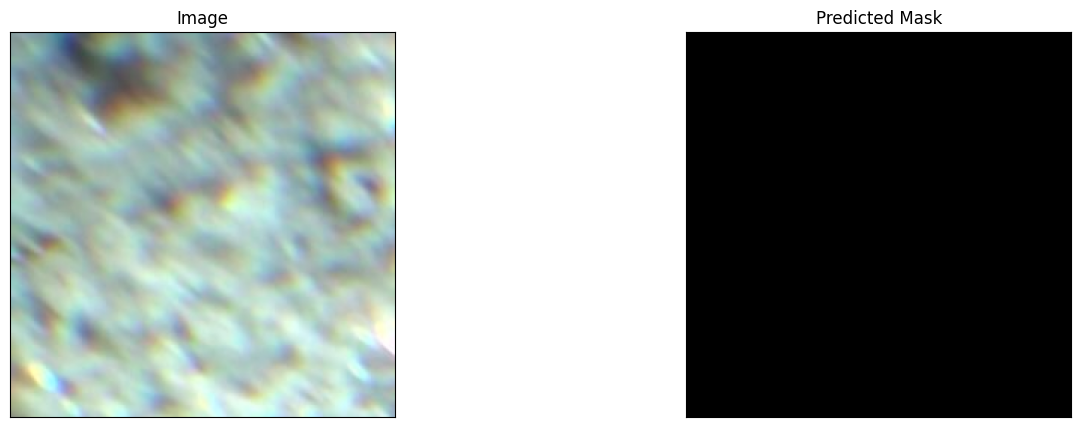

In [19]:
# Cell 9: Predict and Visualize a New Spectral Image
# Example to predict and visualize a new spectral image
spectral_image_path = os.path.join(x_test_dir, 'example_spectral_image.tif')
image, pr_mask = predict_spectral_image(spectral_image_path, best_model, preprocessing_fn, DEVICE)

# Convert predicted mask to single channel for visualization
pr_mask = pr_mask.argmax(axis=0)

visualize(
    image=image,
    predicted_mask=pr_mask
)
